In [1]:
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Load relevant data**

In [2]:
# Translation table
translation_df = pd.read_csv(
    "data/external/candSID_PanAfID_translations_old_platform_2021_11_27.csv"
)
translation_df["video"] = translation_df["clip.id"].str.lower()
translation_df["video_id"] = translation_df["video.id"].str.lower()
translation_df["new_file_name"] = translation_df["new.file.name"].str.lower()
translation_df.drop(
    columns=["Unnamed: 0", "clip.id", "video.id", "new.file.name"], inplace=True
)
translation_df.head(1)

,site,video,video_id,new_file_name
0,taieast,acp000e0ia,taieast_marielyne/taieast_marielyne_camera tra...,y:/primpanaf/22_publications/03_marielyne desp...


In [3]:
# ACP prefixed videos
acp_df = pd.read_csv(
    "data/internal/acp_prefixed_videos.csv", names=["video"], header=None
)
acp_df.video = acp_df.video.str.split(".").str[0].str.lower()
acp_df.head(5)

,video
NaN,0
0.0,acp000capq
1.0,acp000fw7f
2.0,acp000cfoz
3.0,acp00055t9


In [4]:
# Maureens annotations
csv_files = glob(
    "/home/dl18206/Desktop/phd/data/panaf/maureen_annotations/data/sites/csv/**/*.csv",
    recursive=True,
)
sorted_csv_files = sorted(csv_files, key=lambda x: x.split("/")[-1])
initialiser, remainder = sorted_csv_files[0], sorted_csv_files[1:]
df = pd.read_csv(initialiser, encoding="ISO-8859-1")
for file in remainder:
    site = pd.read_csv(file, encoding="ISO-8859-1")
    df = pd.concat([df, site])
df["subdir_video"] = df.subfolder.astype(str) + "_" + df.video_file_name.astype(str)
df["subdir_video"] = df.subdir_video.str.lower()
df["subdir_video"] = df.subdir_video.str.split(".").str[0]
df.head(1)

,new_row_id,country,research_site,genus,species,cam_coverage_area,location_metadata,habitat,utm_zone,utm_long,...,sex,tool_use,vocalization,bipedal,camera_reaction,behavioral_context,other_species,additional_comments,record_type,subdir_video
0,1,mali,bafing,Pan,troglodytes verus,9.87,trail,forest on rock,29n,342661.0,...,male,no,no,no,no,travel,NaN,Not very clear screen,60s_video,baf_vid1_0342661_1432807_20141103_11160014


In [5]:
print(f"Unique videos translation table: {translation_df.video.unique().__len__()}")
print(f"Unique videos translation table: {acp_df.video.unique().__len__() }")

Unique videos translation table: 562805
Unique videos translation table: 19977


**Merge acp-prefixed and translation dataframes**

In [6]:
acp_trans_df = acp_df.merge(translation_df, on="video")
# Create subdir_video column to allow downstream merging
acp_trans_df["subdir_video"] = acp_trans_df.new_file_name.apply(
    lambda x: "_".join(x.split("/")[-2:])
)
acp_trans_df["subdir_video"] = acp_trans_df.subdir_video.apply(
    lambda x: x.split(".")[0]
)
acp_trans_df.drop(columns=["video_id", "new_file_name"], inplace=True)

**Chimp & See annotations**

In [7]:
# Read chimp and see annotations and merge with acp-prefixed and translation dataframes
chimp_df = pd.read_excel(
    "data/internal/Chimp & See master chimpanzee video list 2015-2018_OB_analysis.xlsx",
    sheet_name="Otto's Analysis (Plain Text)",
)
chimp_df["video"] = chimp_df.ID.str.lower()

In [8]:
chimp_df.head()

,ID,Tags,Unnamed: 2,video
0,ACP000002j,chimp camera_reaction 3_chimp infant juvenile ...,QW1,acp000002j
1,ACP000002l,chimp 1_chimp early_morning quietwood juvenile...,QW1,acp000002l
2,ACP00000ga,chimp 1_chimp qwmale25 quietwood,QW1,acp00000ga
3,ACP00000gd,chimp 1_chimp qwmale25 quietwood,QW1,acp00000gd
4,ACP00000gf,chimp 1_chimp qwmale25 quietwood,QW1,acp00000gf


In [9]:
all_df = acp_trans_df.merge(chimp_df, on="video")
all_df["split_tags"] = all_df.Tags.str.split(" ")

In [10]:
all_df.head()

,video,site,subdir_video,ID,Tags,Unnamed: 2,split_tags
0,acp000capq,bwindi,bwi_vid3_809865_9882811_20121217_pict0488,ACP000capq,1_chimp restlessstar nuka-taka bipedal male ad...,RS13,"[1_chimp, restlessstar, nuka-taka, bipedal, ma..."
1,acp000fw7f,taieast,taieast_43_0690693_0644772_20141217+_ek000039,ACP000fw7f,agedviolet crann chimp tool_use juvenile jojo-...,AV15,"[agedviolet, crann, chimp, tool_use, juvenile,..."
2,acp000cfoz,bwindi,bwi_vid11_809049_9882181_20120723_pict0044,ACP000cfoz,chimp needcid 1_chimp restlessstar,RS13,"[chimp, needcid, 1_chimp, restlessstar]"
3,acp00055t9,east_nimba,nim_vid01_0545838_0820109_20131229_ek000021,ACP00055t9,chimp needcid 1_chimp crimsondew female adult,CD8,"[chimp, needcid, 1_chimp, crimsondew, female, ..."
4,acp00072rb,kayan,kay_vid8_0798844_1459074_20130326_pict0020,ACP00072rb,needcid 3_chimp drylake chimp male,DL11,"[needcid, 3_chimp, drylake, chimp, male]"


In [11]:
# Import unique tag analysis
tag_df = pd.read_excel("data/internal/unique_tags 1.xlsx", sheet_name="distilled")

attr = tag_df.columns[1:]
for col in tag_df.columns[1:]:
    unique_tags = tag_df[tag_df[col] == col].tags.unique()
    all_df[col] = all_df.split_tags.apply(
        lambda x: 1 if any(i in x for i in unique_tags) else 0
    )

# Create column indicating empties
all_df["label_indicator"] = (
    all_df[tag_df.columns[1:]]
    .astype(int)
    .apply(lambda x: True if any([i for i in x]) else False, axis=1)
)

# Apply the lambda function (to convert binary columns to a multiclass label) to each row to create a new column 'label'
to_label = lambda x: ",".join([str(i) for i in x])
all_df["label"] = (
    all_df[tag_df.columns[1:]].astype(int).apply(to_label, axis=1).astype("category")
)
all_df["label"] = all_df.label.str.split(",")
all_df["label"] = all_df.label.apply(lambda x: [int(i) for i in x])

In [13]:
# all_df.to_csv('C&S_annotated_acp_videos.csv', index=False)
all_df.columns

Index(['video', 'site', 'subdir_video', 'ID', 'Tags', 'Unnamed: 2',
       'split_tags', 'camera_reaction', 'tool_use', 'bipedal', 'feeding',
       'chimp_carrying', 'vocalisation', 'climbing', 'aggression', 'travel',
       'sex', 'drinking', 'piloerection', 'social_interaction', 'defecating',
       'display', 'grooming', 'tool_use_surface', 'tool_use_mound', 'swelling',
       'night_chimps', 'off_camera', 'label_indicator', 'label'],
      dtype='object')

**Investigate videos without any behavioural annotation**

In [14]:
acp_trans_panaf_df = acp_trans_df.merge(df, on="subdir_video")
acp_trans_panaf_df.head()

,video,site,subdir_video,new_row_id,country,research_site,genus,species,cam_coverage_area,location_metadata,...,age_class,sex,tool_use,vocalization,bipedal,camera_reaction,behavioral_context,other_species,additional_comments,record_type
0,acp000capq,bwindi,bwi_vid3_809865_9882811_20121217_pict0488,1361,uganda,bwindi,Pan,troglodytes schweinfurthii,11.20,trail,...,adult,male,NaN,NaN,NaN,NaN,climbing,NaN,NaN,60s_video
1,acp000capr,bwindi,bwi_vid3_809865_9882811_20121217_pict0488,1361,uganda,bwindi,Pan,troglodytes schweinfurthii,11.20,trail,...,adult,male,NaN,NaN,NaN,NaN,climbing,NaN,NaN,60s_video
2,acp000caps,bwindi,bwi_vid3_809865_9882811_20121217_pict0488,1361,uganda,bwindi,Pan,troglodytes schweinfurthii,11.20,trail,...,adult,male,NaN,NaN,NaN,NaN,climbing,NaN,NaN,60s_video
3,acp000capt,bwindi,bwi_vid3_809865_9882811_20121217_pict0488,1361,uganda,bwindi,Pan,troglodytes schweinfurthii,11.20,trail,...,adult,male,NaN,NaN,NaN,NaN,climbing,NaN,NaN,60s_video
4,acp000cfoz,bwindi,bwi_vid11_809049_9882181_20120723_pict0044,56,uganda,bwindi,Pan,troglodytes schweinfurthii,24.51,trail,...,adolescent,male,NaN,NaN,NaN,NaN,travel,NaN,NaN,60s_video


In [15]:
# Filter ONLY videos which have 0 behavioural annotation
no_annotations = all_df[all_df.label_indicator == False]["video"]
acp_trans_df = acp_trans_df[acp_trans_df.video.isin(no_annotations)]

In [16]:
# Merging PanAf annotations with new platform
acp_trans_panaf_df = acp_trans_df.merge(df, on="subdir_video")

In [17]:
(
    acp_trans_panaf_df.behavioral_context.value_counts()
    / acp_trans_panaf_df.behavioral_context.value_counts().sum()
) * 100

travel             44.255987
feeding            33.725952
climbing            8.197880
resting             4.687868
unclear             2.669808
camera reaction     1.743227
playing             1.295642
tool use            1.107185
tool use nuts       1.005104
displaying          0.612485
grooming            0.369062
sexual              0.141343
greeting            0.094229
reassurance         0.047114
aggression          0.047114
Name: behavioral_context, dtype: float64

In [18]:
# Remove all columns except video_id and behavioural context
acp_trans_panaf_df.drop(
    acp_trans_panaf_df.columns.difference(
        [
            "video",
            "behavioral_context",
            "tool_use",
            "vocalization",
            "bipedal",
            "camera_reaction",
        ]
    ),
    1,
    inplace=True,
)
acp_trans_panaf_df.fillna("no", inplace=True)

# Convert behavioural context to multiple columns with binary indicators
behavioural_context_df = pd.get_dummies(
    acp_trans_panaf_df, columns=["behavioral_context"]
)
behavioural_context_df.replace(
    {"yes": 1, "off_camera": 1, "offscreen": 1, "no": 0}, inplace=True
)

# Unify labels for multiple sub classes
behavioural_context_df["true_tool_use"] = (
    (behavioural_context_df.tool_use == 1)
    | (behavioural_context_df["behavioral_context_tool use"] == 1)
    | (behavioural_context_df["behavioral_context_tool use nuts"] == 1)
)
behavioural_context_df["true_camera_reaction"] = (
    behavioural_context_df["camera_reaction"] == 1
) | (behavioural_context_df["behavioral_context_camera reaction"] == 1)
behavioural_context_df["true_tool_use"] = behavioural_context_df[
    "true_tool_use"
].astype(int)
behavioural_context_df["true_camera_reaction"] = behavioural_context_df[
    "true_camera_reaction"
].astype(int)

<ipython-input-18-ae7ef703a7a5>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  acp_trans_panaf_df.drop(


In [19]:
behavioural_context_df.drop(
    columns=[
        "tool_use",
        "camera_reaction",
        "behavioral_context_camera reaction",
        "behavioral_context_greeting",
        "behavioral_context_resting",
        "behavioral_context_tool use",
        "behavioral_context_tool use nuts",
        "behavioral_context_unclear",
    ],
    inplace=True,
)

In [20]:
behavioural_context_df.columns

Index(['video', 'vocalization', 'bipedal', 'behavioral_context_aggression',
       'behavioral_context_climbing', 'behavioral_context_displaying',
       'behavioral_context_feeding', 'behavioral_context_grooming',
       'behavioral_context_playing', 'behavioral_context_reassurance',
       'behavioral_context_sexual', 'behavioral_context_travel',
       'true_tool_use', 'true_camera_reaction'],
      dtype='object')

In [21]:
behavioural_context_df.rename(
    columns={
        "vocalization": "vocalisation",
        "behavioral_context_aggression": "aggression",
        "behavioral_context_climbing": "climbing",
        "behavioral_context_displaying": "display",
        "behavioral_context_feeding": "feeding",
        "behavioral_context_grooming": "grooming",
        "behavioral_context_sexual": "sex",
        "behavioral_context_travel": "travel",
        "true_tool_use": "tool_use",
        "true_camera_reaction": "camera_reaction",
    },
    inplace=True,
)

behavioural_context_df["social_interaction"] = (
    behavioural_context_df.behavioral_context_playing == 1
) | (behavioural_context_df.behavioral_context_reassurance == 1)
behavioural_context_df["social_interaction"] = behavioural_context_df[
    "social_interaction"
].astype(int)
behavioural_context_df.drop(
    columns=["behavioral_context_playing", "behavioral_context_reassurance"],
    inplace=True,
)

In [22]:
behavioural_context_df["label_indicator"] = (
    behavioural_context_df[behavioural_context_df.columns[1:]]
    .astype(int)
    .apply(lambda x: True if any([i for i in x]) else False, axis=1)
)
behavioural_context_df = behavioural_context_df[
    behavioural_context_df.label_indicator == True
].drop(columns=["label_indicator"], axis=1)

In [23]:
to_label = lambda x: ",".join([str(i) for i in x])

# Apply the lambda function to each row to create a new column 'label'
behavioural_context_df["label"] = (
    behavioural_context_df[behavioural_context_df.columns[1:]]
    .apply(to_label, axis=1)
    .astype("category")
)
behavioural_context_df["label"] = behavioural_context_df.label.str.split(",")
behavioural_context_df["label"] = behavioural_context_df.label.apply(
    lambda x: str([int(i) for i in x])
)

In [24]:
multi_label_df = (
    behavioural_context_df.groupby("video")["label"]
    .apply(lambda x: True if len(x.unique()) == 1 else False)
    .reset_index()
)
multi_label_df = multi_label_df[multi_label_df.label == True]

In [25]:
videos2keep = multi_label_df.video
behavioural_context_df = behavioural_context_df[
    behavioural_context_df.video.isin(videos2keep)
]

In [26]:
behavioural_context_df.drop(
    behavioural_context_df.columns.difference(["video", "travel", "feeding"]),
    axis=1,
    inplace=True,
)

**Combine ACP-prefixed data with Maureens annotations**

In [27]:
all_df = all_df[all_df.label_indicator == True]
all_df.drop(
    columns=[
        "site",
        "subdir_video",
        "ID",
        "Tags",
        "Unnamed: 2",
        "split_tags",
        "label_indicator",
        "label",
    ],
    inplace=True,
)

missing_columns = [x for x in all_df.columns if x not in behavioural_context_df.columns]
for col in missing_columns:
    behavioural_context_df[col] = 0
final_df = pd.concat([all_df, behavioural_context_df]).drop_duplicates()

<ipython-input-27-629b27cc09a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_df.drop(


**Process final df: index cols, add label indicator etc.**

In [35]:
sorted_columns_df = final_df.reindex(sorted(all_df.columns[1:-5]), axis=1)
video_df = final_df[final_df.columns[:1]]
indicator_df = final_df[final_df.columns[-5:]]
final_df = pd.concat([video_df, indicator_df, sorted_columns_df], axis=1)

# Create column indicating empties
final_df["label_indicator"] = (
    final_df[final_df.columns[6:]]
    .astype(int)
    .apply(lambda x: True if any([i for i in x]) else False, axis=1)
)

final_df = final_df[final_df.label_indicator == True].drop(columns=["label_indicator"])

**Qualitative testing: vis samples**

In [36]:
final_df

,video,tool_use_surface,tool_use_mound,swelling,night_chimps,off_camera,aggression,bipedal,camera_reaction,chimp_carrying,...,display,drinking,feeding,grooming,piloerection,sex,social_interaction,tool_use,travel,vocalisation
0,acp000capq,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,acp000fw7f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,acp000b37u,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,acp0002rqx,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,acp000cwcu,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12712,acp000c4li,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12718,acp000ba92,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12719,acp000bb8w,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12721,acp000dtt9,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


**Summary and distribution**

In [37]:
# # Plot freq dist
# attr = final_df.columns[6:]
# counts = final_df[attr].sum(axis=0).sort_values(ascending=False)  # occurence counts
# ax = counts.plot.bar(figsize=(15, 5), width=0.5)
# plt.yscale("log")
# ax.set_xlabel("Behaviours")
# ax.set_ylabel("Occurence")
# plt.savefig("foo.pdf")

In [38]:
# counts.plot.pie(subplots=True, figsize=(15, 5), logx=True)

In [39]:
# # Plot co-occurence matrix
# coocc_df = final_df[attr].astype(int)
# coocc = coocc_df.T.dot(coocc_df)

# # Make sure it is relative for vis
# diag = np.diag(coocc)
# rel_co_matrix = np.array([1 / x for x in diag]) * coocc

# # Plot
# plt.figure(figsize=(15, 10))
# sns.heatmap(rel_co_matrix, cmap="rocket_r")

In [42]:
# Apply the lambda function to each row to create a new column 'label'
final_df["label"] = (
    final_df[final_df.columns[6:]].apply(to_label, axis=1).astype("category")
)
final_df["label"] = final_df.label.str.split(",")
final_df["label"] = final_df.label.apply(lambda x: str([int(i) for i in x]))

**Generate train-test splits**

In [44]:
from skmultilearn.model_selection import iterative_train_test_split

In [46]:
X = final_df.video.to_numpy().reshape((11390, 1))
labels = final_df[final_df.columns[6:-1]].to_numpy()

In [49]:
X_train, y_train, X_test, y_test = iterative_train_test_split(X, labels, test_size=0.30)

In [50]:
# Train df
train_x_df = pd.DataFrame(X_train, columns=["video"])
train_y_df = pd.DataFrame(y_train, columns=final_df.columns[6:-1])
train_df = pd.concat([train_x_df, train_y_df], axis=1)

In [51]:
# Test df
test_x_df = pd.DataFrame(X_test, columns=["video"])
test_y_df = pd.DataFrame(y_test, columns=final_df.columns[6:-1])
test_df = pd.concat([test_x_df, test_y_df], axis=1)

In [52]:
final_df.columns[6:-1]

Index(['aggression', 'bipedal', 'camera_reaction', 'chimp_carrying',
       'climbing', 'defecating', 'display', 'drinking', 'feeding', 'grooming',
       'piloerection', 'sex', 'social_interaction', 'tool_use', 'travel',
       'vocalisation'],
      dtype='object')

In [53]:
for dataframe in [train_df, test_df]:
    dataframe["label"] = (
        dataframe[dataframe.columns[1:]].apply(to_label, axis=1).astype("category")
    )
    dataframe["label"] = dataframe.label.str.split(",")
    dataframe["label"] = dataframe.label.apply(lambda x: str([int(i) for i in x]))

In [57]:
train_df.to_csv("train.csv", index=False)
test_df.to_csv("val.csv", index=False)

**Dataset figures**

In [2]:
# PanAf500
p500 = {
    "climbing_down": 1428,
    "standing": 42508,
    "walking": 62698,
    "sitting": 75325,
    "sitting_on_back": 2457,
    "climbing_up": 4219,
    "camera_interaction": 1939,
    "hanging": 8814,
    "running": 2128,
}

# PanAf20k
p20k = {
    "feeding": 4459,
    "travel": 2031,
    "tool_use": 1795,
    "camera_reaction": 1630,
    "vocalisation": 1177,
    "chimp_carrying": 1163,
    "climbing": 166,
    "bipedal": 165,
    "social_interaction": 116,
    "grooming": 65,
    "piloerection": 54,
    "display": 44,
    "aggression": 38,
    "defecating": 28,
    "drinking": 8,
    "sex": 3,
}

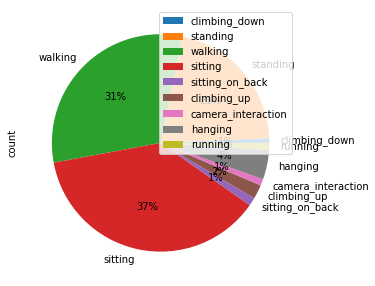

In [3]:
# PanAf500
p500 = pd.DataFrame.from_dict(p500, orient="index", columns=["count"])
p500["behaviour"] = p500.index.values
p500.reset_index(drop=True, inplace=True)
pie = p500.plot.pie(
    y="count", labels=p500["behaviour"], autopct="%.0f%%", figsize=(5, 5)
)
fig = pie.get_figure()
# fig.savefig("p500_pie.pdf")

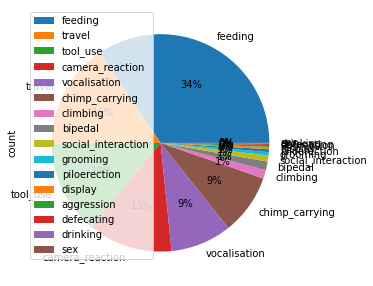

In [4]:
p20k_df = pd.DataFrame.from_dict(p20k, orient="index", columns=["count"])
p20k_df["behaviour"] = p20k_df.index.values
p20k_df.reset_index(drop=True, inplace=True)
p20k_df.plot.pie(
    y="count", labels=p20k_df["behaviour"], autopct="%.0f%%", figsize=(5, 5)
)
fig = pie.get_figure()

([<matplotlib.patches.Wedge at 0x7f809268ab80>,
 [Text(0.40930061039958754, 1.021015675847597, 'carots'),
  Text(-1.0872330717696463, 0.16710549856404816, 'potatoes'),
  Text(0.11720543261763929, -1.0937380337927873, 'tomatos'),
  Text(1.0918234479392777, -0.1338714253677303, 'vegetables')],
 [Text(0.223254878399775, 0.5569176413714165, '38%'),
  Text(-0.5930362209652617, 0.09114845376220808, '19%'),
  Text(0.06393023597325778, -0.5965843820687929, '39%'),
  Text(0.5955400625123332, -0.07302077747330743, '4%')])

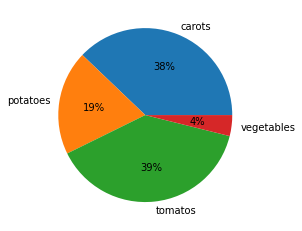

In [5]:
df = pd.DataFrame(
    [["potatoes", 20], ["carots", 39], ["tomatos", 40], ["apples", 2], ["bananas", 2]],
    columns=["aliments", "number"],
)

df_draw = df.copy()
df_draw.loc[df_draw["number"] < 20, "aliments"] = "vegetables"

df_draw = df_draw.groupby("aliments")["number"].sum().reset_index()

plt.pie(df_draw["number"], labels=df_draw["aliments"], autopct="%.0f%%")

In [6]:
# PanAf20k
p20k = {
    "feeding": 4459,
    "travel": 2031,
    "tool_use": 1795,
    "camera_reaction": 1630,
    "vocalisation": 1177,
    "chimp_carrying": 1163,
    "climbing": 166,
    "bipedal": 165,
    "social_interaction": 116,
    "grooming": 65,
    "piloerection": 54,
    "display": 44,
    "aggression": 38,
    "defecating": 28,
    "drinking": 8,
    "sex": 3,
}

total = sum(p20k.values())
for x, y in p20k.items():
    print(x, y / total)

feeding 0.3445371658167208
travel 0.15693092257765415
tool_use 0.13869571936331324
camera_reaction 0.12594653067532066
vocalisation 0.09094421264101375
chimp_carrying 0.08986246329779014
climbing 0.01282645649822284
bipedal 0.012749188687992583
social_interaction 0.008963065986709937
grooming 0.005022407664966775
piloerection 0.004172461752433936
display 0.0033997836501313554
aggression 0.0029361767887498068
defecating 0.002163498686447226
drinking 0.0006181424818420646
sex 0.0002318034306907742


In [7]:
p20k = {
    "feeding": 4459,
    "travel": 2031,
    "tool_use": 1795,
    "camera_reaction": 1630,
    "vocalisation": 1177,
    "chimp_carrying": 1163,
    "climbing": 166,
    "bipedal": 165,
    "social_interaction": 116,
    "grooming": 65,
    "piloerection": 54,
    "display": 44,
    "aggression": 38,
    "defecating": 28,
    "drinking": 8,
    "sex": 3,
}

In [8]:
p20k = {
    "feeding": {
        "feeding": 373,
        "wood_eating": 2340,
    },
    "tool_use": {
        "tool_use": 1625,
        "tool_carry": 195,
        "termite_fishing": 105,
        "nut_cracking": 156,
        "honey_pound": 29,
    },
    "camera_reaction": {
        "camera_reaction_main": 1614,
        "camera_reaction_attraction": 59,
        "selfie": 74,
    },
    "vocalisation": {
        "vocalisation": 1169,
        "hoot": 86,
        "grunt": 36,
    },
    "chimp_carrying": {
        "chimp_carrying": 1163,
    },
    "climbing": {
        "climbing": 166,
    },
    "bipedal": {
        "bipedal": 165,
    },
    "social_interaction": {
        "social_interaction": 116,
        "grooming": 65,
    },
    "aggression": {
        "aggression": 36,
        "charge": 1,
        "fight": 3,
    },
    "travel": {
        "running": 1,
        "walking": 2,
        "travel": 2031,
    },
    "display": {
        "branch_shaking": 15,
        "display": 28,
        "stone_throw": 12,
    },
    "defecating": {
        "defecating": 28,
    },
    "sex": {
        "sex": 3,
    },
    "drinking": {
        "drinking": 8,
    },
    "piloerection": {
        "piloerection": 54,
    },
}

In [9]:
p20k = {
    "feeding": {
        "feeding": 373,
        "wood_eating": 2340,
    },
    "tool_use": {
        "tool_use": 1625,
        "tool_carry": 195,
        "termite_fishing": 105,
        "nut_cracking": 156,
        "honey_pound": 29,
    },
    "camera_reaction": {
        "camera_reaction_main": 1614,
        "camera_reaction_attraction": 59,
        "selfie": 74,
    },
    "vocalisation": {
        "vocalisation": 1169,
        "hoot": 86,
        "grunt": 36,
    },
    "chimp_carrying": {
        "chimp_carrying": 1163,
    },
    "climbing": {
        "climbing": 166,
    },
    "bipedal": {
        "bipedal": 165,
    },
    "social_interaction": {
        "social_interaction": 116,
        "grooming": 65,
    },
    "travel": {
        "running": 1,
        "walking": 2,
        "travel": 2031,
    },
    "other": {
        "display": 65,
        "piloerection": 54,
        "defecating": 28,
        "drinking": 8,
        "aggression": 40,
        "sex": 3,
    },
}

In [39]:
parent_classes = {
    "p_camera_reaction": 2239,
    "p_tool_use": 1153,
    "p_object_carrying": 656,
    "p_bipedal": 142,
    "p_feeding": 6305,
    "p_chimp_carrying": 1906,
    "p_vocalisation": 1032,
    "p_climbing": 2043,
    "p_aggression": 176,
    "p_travel": 5224,
    "p_sex": 166,
    "p_piloerection": 51,
    "p_social_interaction": 1955,
    "p_grooming": 665,
    "p_display": 219,
    "p_cross_species_interaction": 115,
    "p_resting": 4304,
    "p_playing": 1039,
    "p_no_behaviour": 4416,
}

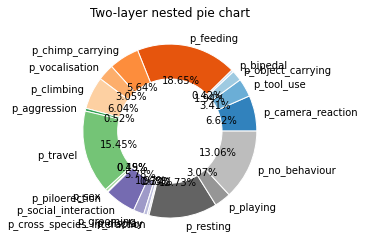

<Figure size 1440x1440 with 0 Axes>

In [40]:
import matplotlib.pyplot as plt

data = parent_classes

# Extract the outer categories and their sizes
outer_labels = list(data.keys())
outer_sizes = list(data.values())

# Define the colors for the inner and outer layers
colours = []
outer_colors = plt.cm.tab20c.colors

# Create different shades of the outer color for the inner ring
for i, outer in enumerate(outer_colors):
    colours = outer_colors[i]

# Create the two-layer nested pie chart
fig, ax = plt.subplots()
ax.pie(
    outer_sizes,
    labels=outer_labels,
    colors=outer_colors,
    wedgeprops=dict(width=0.6, edgecolor="w"),
    radius=1.0,
    autopct="%.2f%%",
)

# Add a circle in the center to make it a donut chart
ax.add_artist(plt.Circle((0, 0), 0.6, color="white"))

# Set the title and show the chart
ax.set_title("Two-layer nested pie chart")
plt.savefig("parent_class_pie.pdf")
plt.figure(figsize=(20, 20))
plt.show()

In [10]:
p20k_subclass = {
    "camera_reaction_main": 1614,
    "camera_reaction_attraction": 59,
    "off_camera": 300,
    "tool_use": 1625,
    "tool_carry": 195,
    "termite_fishing": 105,
    "nut_cracking": 156,
    "tool_use_surface": 7,
    "tool_use_mound": 96,
    "stone_throw": 12,
    "honey_pound": 29,
    "swelling": 596,
    "selfie": 74,
    "bipedal": 165,
    "night_chimps": 242,
    "feeding": 373,
    "wood_eating": 2340,
    "chimp_carrying": 1163,
    "vocalisation": 1169,
    "running": 1,
    "walking": 2,
    "climbing": 166,
    "standing": 1,
    "aggression": 36,
    "charge": 1,
    "travel": 57,
    "fight": 3,
    "branch_shaking": 15,
    "hoot": 86,
    "grunt": 36,
    "sex": 3,
    "water": 0,
    "drinking": 8,
    "piloerection": 54,
    "social_interaction": 116,
    "defecating": 28,
    "display": 28,
    "grooming": 65,
    "smelling": 1,
}

In [11]:
for l, x in zip(outer_labels, outer_sizes):
    print(l, x / sum(outer_sizes))

NameError: name 'outer_labels' is not defined

[2713, 2110, 1747, 1291, 1163, 166, 165, 181, 2034, 198]


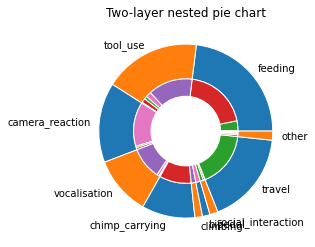

In [19]:
import matplotlib.pyplot as plt

# Define a nested dictionary
data = {
    "Outer Category 1": {"Inner Category 1A": 20, "Inner Category 1B": 30},
    "Outer Category 2": {"Inner Category 2A": 10, "Inner Category 2B": 40},
    "Outer Category 3": {"Inner Category 2A": 10, "Inner Category 2B": 40},
}

data = p20k
# Extract the outer categories and their sizes
outer_labels = list(data.keys())
outer_sizes = [sum(inner_dict.values()) for inner_dict in data.values()]

print(outer_sizes)

# Extract the inner categories and their sizes
inner_labels = [
    inner_key for inner_dict in data.values() for inner_key in inner_dict.keys()
]
inner_sizes = [
    inner_dict[inner_key]
    for inner_dict in data.values()
    for inner_key in inner_dict.keys()
]

# Define the colors for the inner and outer layers
outer_colors = ["tab:blue", "tab:orange"]
inner_colors = ["tab:green", "tab:red", "tab:purple", "tab:pink"]

# Create the two-layer nested pie chart
fig, ax = plt.subplots()
ax.pie(
    outer_sizes,
    labels=outer_labels,
    colors=outer_colors,
    wedgeprops=dict(width=0.4, edgecolor="w"),
)

ax.pie(
    inner_sizes,
    colors=inner_colors,
    radius=0.6,
    wedgeprops=dict(width=0.4, edgecolor="w"),
)

# Add a circle in the center to make it a donut chart
ax.add_artist(plt.Circle((0, 0), 0.4, color="white"))

# Set the title and show the chart
ax.set_title("Two-layer nested pie chart")
# plt.savefig("nested_pie.pdf")
plt.show()

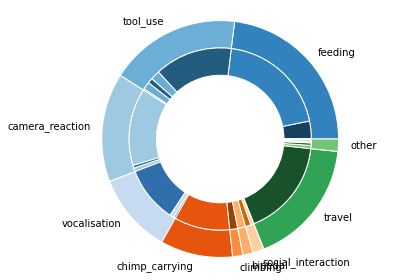

In [24]:
import matplotlib.pyplot as plt
import colorsys

# Nested dictionary sample data
data = p20k

# Extract data and labels for the outer and inner rings
outer_labels, inner_labels, outer_sizes, inner_sizes, inner_colors = [], [], [], [], []
outer_colors = plt.cm.tab20c.colors

for i, (outer_key, inner_dict) in enumerate(data.items()):
    outer_labels.append(outer_key)
    outer_sizes.append(sum(inner_dict.values()))

    for inner_key, value in inner_dict.items():
        inner_labels.append(inner_key)
        inner_sizes.append(value)

        # Create different shades of the outer color for the inner ring
        r, g, b = outer_colors[i]
        h, l, s = colorsys.rgb_to_hls(r, g, b)
        l *= 0.5 + 0.5 * (
            len(inner_colors) % 2
        )  # Alternate between 50% and 100% lightness
        inner_colors.append(colorsys.hls_to_rgb(h, l, s))

# Plot nested pie chart
fig, ax = plt.subplots()
ax.pie(
    outer_sizes,
    labels=outer_labels,
    colors=outer_colors,
    radius=1.3,
    wedgeprops=dict(width=0.3, edgecolor="w"),
)
ax.pie(
    inner_sizes,
    colors=inner_colors,
    radius=1,
    wedgeprops=dict(width=0.3, edgecolor="w"),
)
centre_circle = plt.Circle((0, 0), 0.1, color="white", linewidth=0)

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis("equal")
plt.tight_layout()
plt.show()

# plt.savefig('nested_pie.pdf')
# plt.show()

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
df = pd.DataFrame({"x": ["Market A", "Market B", "Market C"], "y": [45, 35, 20]})

In [16]:
plt.figure(figsize=(8, 8))  # change the size of a figurelabels = df['x’]
sizes = df["y"]
labels = df["x"]

colors = ["#FFB600", "#09A0DA", "#8464a0"]
labels_subgroup = [
    "product A",
    "product B",
    "product C",
    "product D",
    "product E",
    "product F",
    "product G",
]
sizes_subgroup = [20, 15, 10, 20, 15, 10, 10]
colors_subgroup = [
    "#FFCE53",
    "#FFDA7E",
    "#FFE9B2",
    "#30B7EA",
    "#56C7F2",
    "#C8A2C9",
    "#D6A7DF",
]

<Figure size 576x576 with 0 Axes>

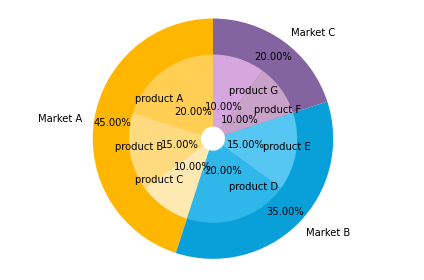

In [17]:
outside_donut = plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    startangle=90,
    frame=True,
    autopct="%.2f%%",
    pctdistance=0.85,
)
inside_donut = plt.pie(
    sizes_subgroup,
    labels=labels_subgroup,
    colors=colors_subgroup,
    radius=0.7,
    startangle=90,
    labeldistance=0.6,
    autopct="%.2f%%",
    pctdistance=0.4,
)
centre_circle = plt.Circle((0, 0), 0.1, color="white", linewidth=0)

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis("equal")
plt.tight_layout()
plt.show()